In [1]:
from pathlib import Path

import h5py

from src.hdf5_utils import *

JSON_DIR   = Path("/home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-21_05-13-37/metadata")
CSV_FILE   = Path("/home/nikolai/OrbitAll/data/TZP_data/molecules/molecules.csv")

DFT_LABEL  = "M06-2X"
OUTPUT_H5  = f"{DFT_LABEL}_CP2K_20k.hdf5"
OUTPUT_H5_TBLITE = OUTPUT_H5.replace(".hdf5", "_tblite.hdf5")

EV_TO_HARTREE = 0.0367493
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 16000, 2000, 2000
SEED = 42

def main() -> None:
    df = load_molecules_csv(CSV_FILE)

    idx_to_npz = build_idx_to_npz(JSON_DIR)
    print(f"Found {len(idx_to_npz)} successful matrices.npz files")

    available = compute_available_indices(idx_to_npz, df, DFT_LABEL)
    print(f"Usable indices (success ∩ CSV ∩ non-NaN {DFT_LABEL}): {len(available)}")

    splits = make_splits(
        available=available,
        train_size=TRAIN_SIZE,
        val_size=VAL_SIZE,
        test_size=TEST_SIZE,
        seed=SEED,
    ).as_dict()
    print({k: len(v) for k, v in splits.items()})

    with h5py.File(OUTPUT_H5, "w") as f_full, h5py.File(OUTPUT_H5_TBLITE, "w") as f_tbl:
        for split_name, indices in splits.items():
            write_split_pair(
                f_full=f_full,
                f_tbl=f_tbl,
                split_name=split_name,
                indices=indices,
                df=df,
                idx_to_npz=idx_to_npz,
                dft_label=DFT_LABEL,
                ev_to_hartree=EV_TO_HARTREE,
                net_spin_default=0,
            )

    print("\nDone, saved to", OUTPUT_H5)
    print("Done, saved to", OUTPUT_H5_TBLITE)


if __name__ == "__main__":
    main()

Found 20000 successful matrices.npz files
Usable indices (success ∩ CSV ∩ non-NaN M06-2X): 20000
{'train': 16000, 'val': 2000, 'test': 2000}


[train]:   0%|          | 0/16000 [00:00<?, ?it/s]

[val]:   0%|          | 0/2000 [00:00<?, ?it/s]

[test]:   0%|          | 0/2000 [00:00<?, ?it/s]


Done, saved to M06-2X_CP2K_20k.hdf5
Done, saved to M06-2X_CP2K_20k_tblite.hdf5


Loaded 19817 molecules with both energies.
Elements used for reduction: ['H', 'C', 'N', 'O', 'F'] (Z=[1, 6, 7, 8, 9])

=== Fitted atomic cores (no intercept) ===
xTB cores (Ha per atom): {'H': -0.5539244557757385, 'C': -2.0855844365721325, 'N': -3.1883748693455454, 'O': -4.702192441660164, 'F': -5.167133402209222}
M06-2X cores (Ha per atom): {'H': -0.1971632314051167, 'C': -0.4096184022972633, 'N': -0.4611272943877922, 'O': -0.424891572374326, 'F': -0.31259166870644983}

=== Mean ± std ===
ΔE = xTB - M06-2X (Ha): -22.852965 ± 2.266848
Δ(E/N) (Ha):              -1.307539 ± 0.259778
ΔE_reduced (Ha):          0.000042 ± 0.027452


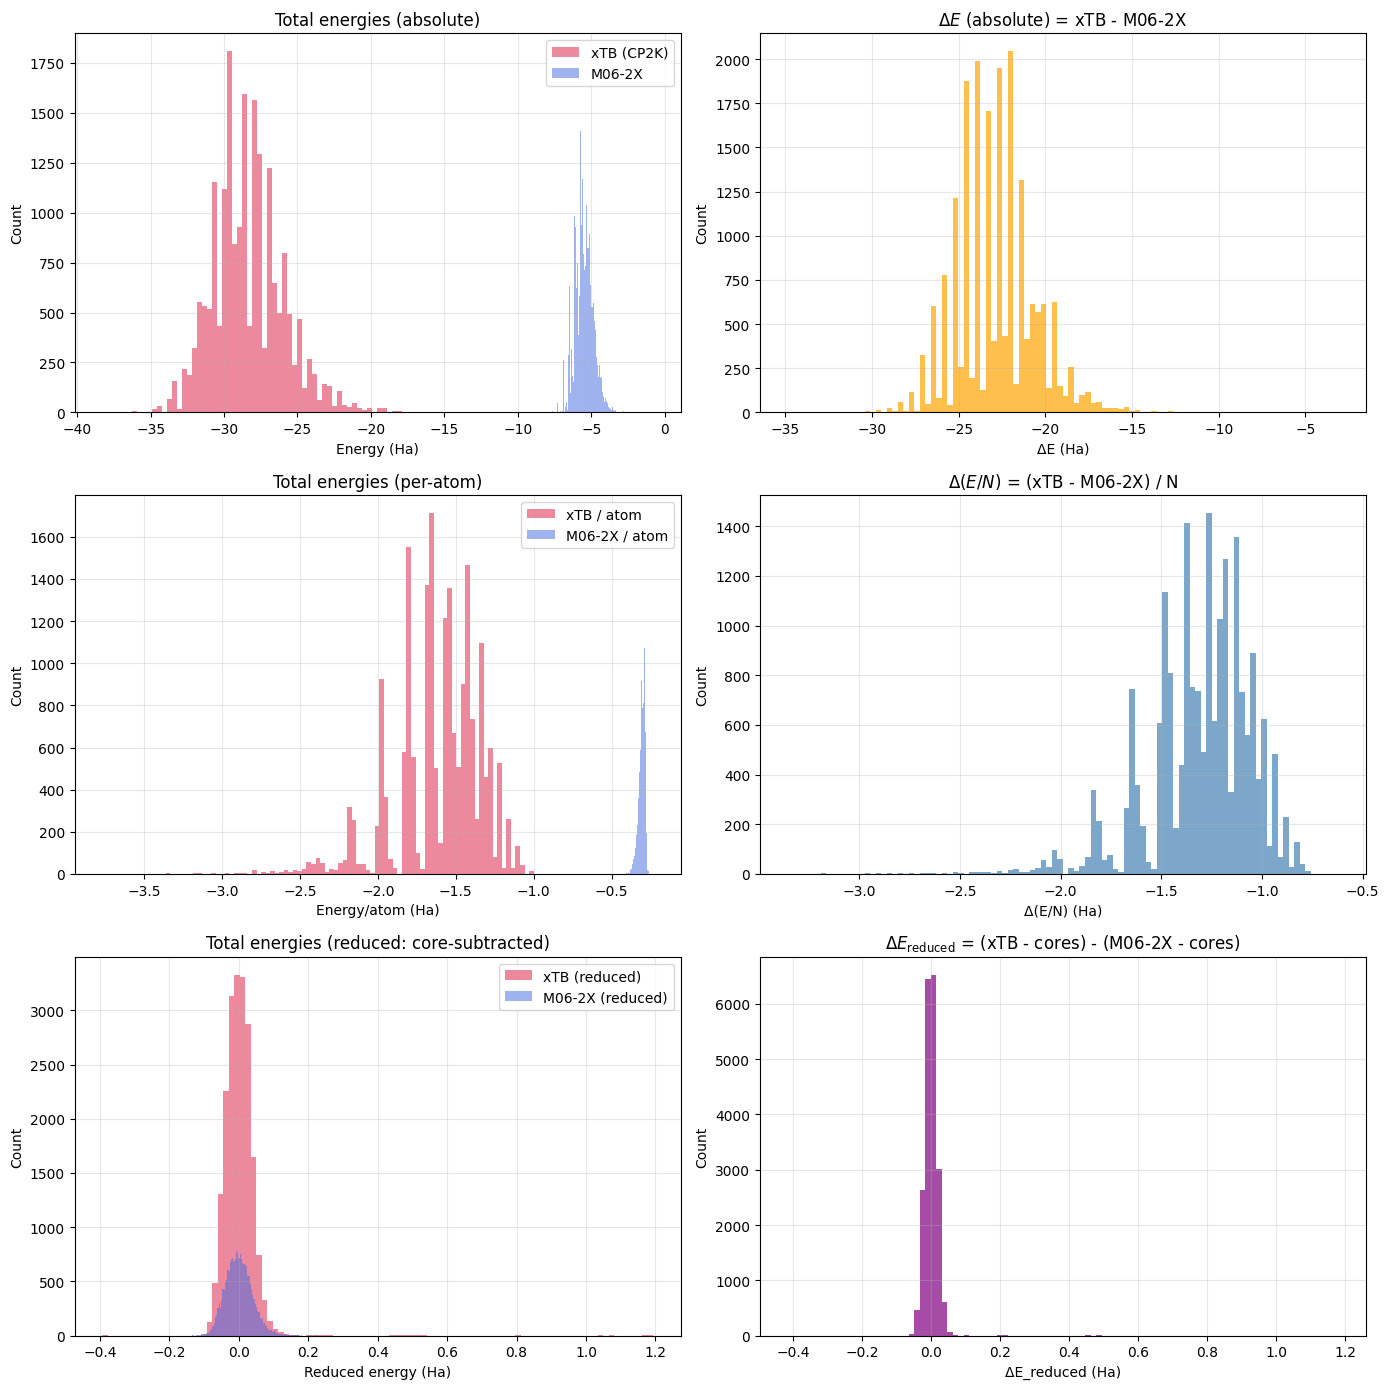

Saved: plots/energy_hists_xtb_vs_M06-2X_Ha_abs_peratom_reduced.png


In [4]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Config
# ---------------------
DFT_LABEL = "M06-2X"
OUTPUT_H5 = f"/home/nikolai/OrbitMat/data/calculations/{DFT_LABEL}_CP2K_20k.hdf5"
SPLITS = ("train", "val", "test")

BINS = 100
SAVE_DIR = "plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Unit conversion
HA_TO_EV = 27.211386245988
HA_TO_KCALMOL = 627.5094740631

UNIT = "Ha"  # "Ha", "eV", "kcal/mol"
if UNIT == "eV":
    conv = HA_TO_EV
elif UNIT == "kcal/mol":
    conv = HA_TO_KCALMOL
else:
    conv = 1.0

# ---------------------
# Helpers
# ---------------------
_PERIODIC = [
    "H","He","Li","Be","B","C","N","O","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar",
    "K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr",
    "Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe",
    "Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu",
    "Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn",
    "Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm","Bk","Cf","Es","Fm","Md","No","Lr",
    "Rf","Db","Sg","Bh","Hs","Mt","Ds","Rg","Cn","Nh","Fl","Mc","Lv","Ts","Og"
]

def z_to_symbol(z: int) -> str:
    return _PERIODIC[z - 1] if 1 <= z <= len(_PERIODIC) else f"Z{z}"

def counts_from_Z(Z: np.ndarray, elements_z: np.ndarray) -> np.ndarray:
    # counts aligned with elements_z order
    # uses bincount for speed, then gather
    bc = np.bincount(Z.astype(int))
    out = np.zeros(len(elements_z), dtype=float)
    for i, z in enumerate(elements_z):
        out[i] = bc[z] if z < len(bc) else 0.0
    return out

# ---------------------
# Load energies + composition from HDF5
# ---------------------
def collect_data(h5_path, splits=SPLITS):
    e_xtb, e_dft, n_atoms, Z_list = [], [], [], []

    dft_key = f"{DFT_LABEL}_energy_Ha"

    with h5py.File(h5_path, "r") as f:
        for split in splits:
            if split not in f:
                continue
            for mol_id in f[split].keys():
                g = f[split][mol_id].get("0", None)
                if g is None:
                    continue

                if dft_key not in g:
                    continue
                if "energy_xtb_Ha" not in g:
                    continue
                if "atomic_numbers" not in g:
                    continue

                Z = g["atomic_numbers"][:].astype(int)
                n = int(len(Z))

                e_xtb.append(float(g["energy_xtb_Ha"][()]))
                e_dft.append(float(g[dft_key][()]))

                n_atoms.append(n)
                Z_list.append(Z)

    if len(e_xtb) == 0:
        raise RuntimeError("No molecules found with both xTB and DFT energies + atomic_numbers.")

    # Determine element set from data
    all_Z = np.unique(np.concatenate(Z_list))
    elements_z = np.array(sorted(all_Z.tolist()), dtype=int)
    elements = [z_to_symbol(int(z)) for z in elements_z]

    # Build design matrix (counts per element)
    X = np.vstack([counts_from_Z(Z, elements_z) for Z in Z_list])

    return (
        np.array(e_xtb, dtype=float),
        np.array(e_dft, dtype=float),
        np.array(n_atoms, dtype=int),
        X,
        elements_z,
        elements,
    )

e_xtb, e_dft, n_atoms, X, elements_z, elements = collect_data(OUTPUT_H5, SPLITS)
print(f"Loaded {len(e_xtb)} molecules with both energies.")
print(f"Elements used for reduction: {elements} (Z={elements_z.tolist()})")

# ---------------------
# Reduced (core-subtracted) energies via linear atomic cores
#   Fit: E ≈ X @ c   (no intercept), separately for xTB and DFT
# ---------------------
coef_xtb, *_ = np.linalg.lstsq(X, e_xtb, rcond=None)
coef_dft, *_ = np.linalg.lstsq(X, e_dft, rcond=None)

res_xtb = e_xtb - X @ coef_xtb
res_dft = e_dft - X @ coef_dft

# ---------------------
# Unit conversions / derived quantities
# ---------------------
e_xtb_u = e_xtb * conv
e_dft_u = e_dft * conv
diff_u = (e_xtb - e_dft) * conv

e_xtb_per_atom = (e_xtb / n_atoms) * conv
e_dft_per_atom = (e_dft / n_atoms) * conv
diff_per_atom = ((e_xtb / n_atoms) - (e_dft / n_atoms)) * conv

res_xtb_u = res_xtb * conv
res_dft_u = res_dft * conv
diff_reduced_u = (res_xtb - res_dft) * conv

# ---------------------
# Summary prints
# ---------------------
cores_xtb = {el: float(c * conv) for el, c in zip(elements, coef_xtb)}
cores_dft = {el: float(c * conv) for el, c in zip(elements, coef_dft)}

print("\n=== Fitted atomic cores (no intercept) ===")
print(f"xTB cores ({UNIT} per atom): {cores_xtb}")
print(f"{DFT_LABEL} cores ({UNIT} per atom): {cores_dft}")

print("\n=== Mean ± std ===")
print(f"ΔE = xTB - {DFT_LABEL} ({UNIT}): {diff_u.mean():.6f} ± {diff_u.std():.6f}")
print(f"Δ(E/N) ({UNIT}):              {diff_per_atom.mean():.6f} ± {diff_per_atom.std():.6f}")
print(f"ΔE_reduced ({UNIT}):          {diff_reduced_u.mean():.6f} ± {diff_reduced_u.std():.6f}")

# ---------------------
# Plot: absolute, per-atom, reduced + their differences
# ---------------------
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Row 1: absolute total energies + difference
axs[0, 0].hist(e_xtb_u, bins=BINS, alpha=0.5, label="xTB (CP2K)", color="crimson")
axs[0, 0].hist(e_dft_u, bins=BINS, alpha=0.5, label=DFT_LABEL, color="royalblue")
axs[0, 0].set_title("Total energies (absolute)")
axs[0, 0].set_xlabel(f"Energy ({UNIT})")
axs[0, 0].set_ylabel("Count")
axs[0, 0].legend()
axs[0, 0].grid(alpha=0.3)

axs[0, 1].hist(diff_u, bins=BINS, alpha=0.7, color="orange")
axs[0, 1].set_title(r"$\Delta E$ (absolute) = xTB - " + DFT_LABEL)
axs[0, 1].set_xlabel(f"ΔE ({UNIT})")
axs[0, 1].set_ylabel("Count")
axs[0, 1].grid(alpha=0.3)

# Row 2: per-atom energies + difference
axs[1, 0].hist(e_xtb_per_atom, bins=BINS, alpha=0.5, label="xTB / atom", color="crimson")
axs[1, 0].hist(e_dft_per_atom, bins=BINS, alpha=0.5, label=f"{DFT_LABEL} / atom", color="royalblue")
axs[1, 0].set_title("Total energies (per-atom)")
axs[1, 0].set_xlabel(f"Energy/atom ({UNIT})")
axs[1, 0].set_ylabel("Count")
axs[1, 0].legend()
axs[1, 0].grid(alpha=0.3)

axs[1, 1].hist(diff_per_atom, bins=BINS, alpha=0.7, color="steelblue")
axs[1, 1].set_title(r"$\Delta(E/N)$ = (xTB - " + DFT_LABEL + r") / N")
axs[1, 1].set_xlabel(f"Δ(E/N) ({UNIT})")
axs[1, 1].set_ylabel("Count")
axs[1, 1].grid(alpha=0.3)

# Row 3: reduced (core-subtracted) energies + reduced difference
axs[2, 0].hist(res_xtb_u, bins=BINS, alpha=0.5, label="xTB (reduced)", color="crimson")
axs[2, 0].hist(res_dft_u, bins=BINS, alpha=0.5, label=f"{DFT_LABEL} (reduced)", color="royalblue")
axs[2, 0].set_title("Total energies (reduced: core-subtracted)")
axs[2, 0].set_xlabel(f"Reduced energy ({UNIT})")
axs[2, 0].set_ylabel("Count")
axs[2, 0].legend()
axs[2, 0].grid(alpha=0.3)

axs[2, 1].hist(diff_reduced_u, bins=BINS, alpha=0.7, color="purple")
axs[2, 1].set_title(r"$\Delta E_\mathrm{reduced}$ = (xTB - cores) - (" + DFT_LABEL + r" - cores)")
axs[2, 1].set_xlabel(f"ΔE_reduced ({UNIT})")
axs[2, 1].set_ylabel("Count")
axs[2, 1].grid(alpha=0.3)

plt.tight_layout()
out_png = os.path.join(
    SAVE_DIR,
    f"energy_hists_xtb_vs_{DFT_LABEL}_{UNIT.replace('/','_')}_abs_peratom_reduced.png"
)
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved:", out_png)

In [7]:
import os
import shutil
import h5py
import numpy as np

# ---------------------
# Config
# ---------------------
SRC_H5 = OUTPUT_H5  # your original file
DST_H5 = SRC_H5.replace(".hdf5", "_filtered_no_top30_tblite_outliers.hdf5")

SPLITS = ("train", "val", "test")
TOPK = 30

# assumes UNIT/conv are already defined in your script
# conv = 1.0  # e.g., if UNIT="Ha"

# ---------------------
# 1) Identify top-K worst (by |energy_xtb_Ha - energy_xtb_Ha_tblite|)
#    We remove at the (split, mol_id, geo) level.
# ---------------------
records = []  # (abs_diff, diff, split, mol_id, geo)

with h5py.File(SRC_H5, "r") as f:
    for split in SPLITS:
        if split not in f:
            continue
        for mol_id in f[split].keys():
            for geo in f[split][mol_id].keys():
                g = f[split][mol_id][geo]
                if "energy_xtb_Ha" not in g or "energy_xtb_Ha_tblite" not in g:
                    continue

                e_xtb = float(g["energy_xtb_Ha"][()])
                e_tbl = float(g["energy_xtb_Ha_tblite"][()])
                d = (e_xtb - e_tbl) * conv  # in UNIT
                records.append((abs(d), d, split, mol_id, geo))

if len(records) == 0:
    raise RuntimeError("No entries found with both energy_xtb_Ha and energy_xtb_Ha_tblite.")

records.sort(key=lambda t: t[0], reverse=True)
worst = records[:TOPK]

print(f"Found {len(records)} comparable geometries. Removing top-{len(worst)} worst by |ΔE|.")
print("Top-5 preview (|ΔE|, ΔE, path):")
for absd, d, split, mol_id, geo in worst[:5]:
    print(f"  |ΔE|={absd:.12f}  ΔE={d:.12f}  {split}/{mol_id}/{geo}")

# Build a quick lookup set for deletion
to_remove = {(split, mol_id, geo) for _, _, split, mol_id, geo in worst}

# ---------------------
# 2) Copy file (keeps original intact)
# ---------------------
if os.path.exists(DST_H5):
    raise FileExistsError(f"Destination already exists: {DST_H5}")
shutil.copy2(SRC_H5, DST_H5)
print(f"Copied:\n  {SRC_H5}\n-> {DST_H5}")

# ---------------------
# 3) Delete those geometries from the COPY, and clean up empty groups
# ---------------------
with h5py.File(DST_H5, "r+") as f:
    for split, mol_id, geo in to_remove:
        if split in f and mol_id in f[split] and geo in f[split][mol_id]:
            del f[split][mol_id][geo]

            # If molecule group has no geometries left, delete molecule
            if len(f[split][mol_id].keys()) == 0:
                del f[split][mol_id]

    # (Optional) If you want to delete empty split groups too:
    for split in SPLITS:
        if split in f and len(f[split].keys()) == 0:
            del f[split]

print("Done. Filtered file written to:", DST_H5)

# ---------------------
# Optional: save removed molecule names/paths
# ---------------------
txt_path = DST_H5.replace(".hdf5", "_removed_top30.txt")
with open(txt_path, "w") as fp:
    fp.write("# Removed entries (highest |energy_xtb_Ha - energy_xtb_Ha_tblite|)\n")
    fp.write(f"# UNIT={UNIT}\n")
    fp.write("rank\tabs_diff\tdiff\tsplit\tmol_id\tgeo\n")
    for r, (absd, d, split, mol_id, geo) in enumerate(worst, start=1):
        fp.write(f"{r}\t{absd:.12f}\t{d:.12f}\t{split}\t{mol_id}\t{geo}\n")
print("Saved removal list to:", txt_path)

Found 19817 comparable geometries. Removing top-30 worst by |ΔE|.
Top-5 preview (|ΔE|, ΔE, path):
  |ΔE|=1.177913025702  ΔE=1.177913025702  train/dsgdb9nsd_010783/0
  |ΔE|=1.156444037113  ΔE=1.156444037113  train/dsgdb9nsd_091543/0
  |ΔE|=1.140149151965  ΔE=1.140149151965  train/dsgdb9nsd_091545/0
  |ΔE|=1.098570415920  ΔE=1.098570415920  train/dsgdb9nsd_114906/0
  |ΔE|=1.095236732843  ΔE=1.095236732843  train/dsgdb9nsd_041572/0
Copied:
  M06-2X_CP2K_20k.hdf5
-> M06-2X_CP2K_20k_filtered_no_top30_tblite_outliers.hdf5
Done. Filtered file written to: M06-2X_CP2K_20k_filtered_no_top30_tblite_outliers.hdf5
Saved removal list to: M06-2X_CP2K_20k_filtered_no_top30_tblite_outliers_removed_top30.txt


In [3]:
from pathlib import Path
import h5py
import numpy as np
import pandas as pd

# -----------------------
# User inputs
# -----------------------
H5_A = Path("/home/nikolai/OrbitMat/data/calculations/M06-2X_CP2K_4k_eps.hdf5")
H5_B = Path("/home/nikolai/OrbitMat/data/calculations/M06-2X_CP2K_4k_tblite.hdf5")

DATASET_A = "energy_xtb_Ha"
DATASET_B = "energy_xtb_Ha_tblite"

SPLITS = ("train", "val", "test")
TOPK = 30

# -----------------------
# Helpers
# -----------------------
def _as_float(x):
    """Convert a scalar h5 dataset read to python float."""
    # h5py returns numpy scalars/arrays; handle both robustly
    arr = np.array(x)
    return float(arr.reshape(-1)[0])

def collect_energies(h5_path: Path, dataset_name: str, splits=SPLITS):
    """
    Return dict: mol_id -> energy (float), searching each split group.
    Expected path: /<split>/<mol_id>/0/<dataset_name>
    """
    energies = {}
    missing = 0
    total = 0

    with h5py.File(h5_path, "r") as f:
        for split in splits:
            if split not in f:
                continue
            gsplit = f[split]
            for mol_id in gsplit.keys():
                total += 1
                base = f"{split}/{mol_id}/0"
                # Ensure group exists
                if base not in f:
                    missing += 1
                    continue
                g0 = f[base]
                if dataset_name not in g0:
                    missing += 1
                    continue
                energies[mol_id] = _as_float(g0[dataset_name][()])
    return energies, {"total_mols_seen": total, "missing_dataset_or_path": missing, "n_loaded": len(energies)}

# -----------------------
# Load energies from both files
# -----------------------
ener_a, stats_a = collect_energies(H5_A, DATASET_A)
ener_b, stats_b = collect_energies(H5_B, DATASET_B)

print("File A:", H5_A)
print("  stats:", stats_a)
print("File B:", H5_B)
print("  stats:", stats_b)

# -----------------------
# Compare on intersection of molecule IDs
# -----------------------
ids_a = set(ener_a.keys())
ids_b = set(ener_b.keys())
common = sorted(ids_a & ids_b)

only_a = sorted(ids_a - ids_b)
only_b = sorted(ids_b - ids_a)

print(f"\nCommon molecules: {len(common)}")
print(f"Only in A:        {len(only_a)}")
print(f"Only in B:        {len(only_b)}")

rows = []
for mol_id in common:
    ea = ener_a[mol_id]
    eb = ener_b[mol_id]
    diff = ea - eb
    rows.append((mol_id, ea, eb, diff, abs(diff)))

df = pd.DataFrame(rows, columns=["mol_id", DATASET_A, DATASET_B, "diff_Ha_(A-B)", "abs_diff_Ha"])
df.sort_values("abs_diff_Ha", ascending=False, inplace=True)

# -----------------------
# Report top K disagreements
# -----------------------
top = df.head(TOPK).reset_index(drop=True)

pd.set_option("display.max_rows", TOPK)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 140)

print(f"\nTop {TOPK} worst disagreements (by |A-B| in Hartree):")
display(top)

# -----------------------
# Optional: summary statistics
# -----------------------
if len(df) > 0:
    print("\nSummary on common molecules:")
    print(f"  mean(abs diff)  : {df['abs_diff_Ha'].mean():.6e} Ha")
    print(f"  median(abs diff): {df['abs_diff_Ha'].median():.6e} Ha")
    print(f"  max(abs diff)   : {df['abs_diff_Ha'].max():.6e} Ha")
    print(f"  mean(diff)      : {df['diff_Ha_(A-B)'].mean():.6e} Ha")
    print(f"  std(diff)       : {df['diff_Ha_(A-B)'].std(ddof=1):.6e} Ha")

# -----------------------
# Optional: save results
# -----------------------
OUT_CSV = Path("xtb_vs_tblite_energy_disagreements.csv")
df.to_csv(OUT_CSV, index=False)
print(f"\nSaved full comparison table to: {OUT_CSV.resolve()}")

File A: /home/nikolai/OrbitMat/data/calculations/M06-2X_CP2K_4k_eps.hdf5
  stats: {'total_mols_seen': 4000, 'missing_dataset_or_path': 0, 'n_loaded': 4000}
File B: /home/nikolai/OrbitMat/data/calculations/M06-2X_CP2K_4k_tblite.hdf5
  stats: {'total_mols_seen': 4000, 'missing_dataset_or_path': 0, 'n_loaded': 4000}

Common molecules: 4000
Only in A:        0
Only in B:        0

Top 30 worst disagreements (by |A-B| in Hartree):


,mol_id,energy_xtb_Ha,energy_xtb_Ha_tblite,diff_Ha_(A-B),abs_diff_Ha
0,dsgdb9nsd_086205,-34.785731,-34.786084,0.000352,0.000352
1,dsgdb9nsd_101685,-35.847977,-35.848254,0.000277,0.000277
2,dsgdb9nsd_102540,-34.738849,-34.739113,0.000264,0.000264
3,dsgdb9nsd_117827,-34.344740,-34.344980,0.000240,0.000240
4,dsgdb9nsd_010783,-30.058242,-30.058481,0.000239,0.000239
5,dsgdb9nsd_104839,-32.694047,-32.694286,0.000239,0.000239
6,dsgdb9nsd_104810,-30.657831,-30.658069,0.000238,0.000238
7,dsgdb9nsd_060634,-32.721168,-32.721402,0.000234,0.000234
8,dsgdb9nsd_105506,-32.724870,-32.725102,0.000231,0.000231
9,dsgdb9nsd_102401,-33.243746,-33.243977,0.000230,0.000230



Summary on common molecules:
  mean(abs diff)  : 1.040439e-04 Ha
  median(abs diff): 1.022743e-04 Ha
  max(abs diff)   : 3.522743e-04 Ha
  mean(diff)      : 1.040232e-04 Ha
  std(diff)       : 4.019266e-05 Ha

Saved full comparison table to: /home/nikolai/OrbitMat/data/calculations/xtb_vs_tblite_energy_disagreements.csv


In [3]:
from pathlib import Path
import pandas as pd

# Assumes `df` already exists and is sorted by abs_diff_Ha descending (as in your script)
TOPK = 30

# Change this to the correct run root that contains dsgdb9nsd_XXXXXX folders
BASE_OUT_DIR = Path("/home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02")

def mol_dir_from_id(mol_id: str) -> Path:
    return (BASE_OUT_DIR / mol_id).resolve()

top = df.head(TOPK).reset_index(drop=True)

print(f"Top {TOPK} offender folders under: {BASE_OUT_DIR}\n")
for i, mol_id in enumerate(top["mol_id"].tolist(), start=1):
    p = mol_dir_from_id(mol_id)
    status = "" if p.exists() else "  (missing)"
    print(f"{i:02d}  {mol_id}  {p}{status}")

Top 30 offender folders under: /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02

01  dsgdb9nsd_010783  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_010783
02  dsgdb9nsd_091545  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_091545
03  dsgdb9nsd_114906  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_114906
04  dsgdb9nsd_041572  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_041572
05  dsgdb9nsd_040764  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_040764
06  dsgdb9nsd_059634  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_059634
07  dsgdb9nsd_037524  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_037524
08  dsgdb9nsd_119577  /home/nikolai/OrbitMat/data/calculations/out/xyz_2025-12-18_16-12-02/dsgdb9nsd_119577
09  dsgdb9nsd_058422  /home/nikolai